In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import re
from collections import defaultdict
from typing import LiteralString, Sequence, Literal
from datetime import datetime, timedelta

In [3]:
sample_idxes = set([41905, 7296, 1639, 48598, 18024, 16049, 14628,
                9144, 48265, 6717, 44348, 48540, 58469, 35741])

In [4]:
def extract_log(files:list[LiteralString]):
    # Regular expression to capture sample number and checking done time
    sample_no_pattern = r"for sample (\d+)"
    time_pattern = r"time (\d+\.\d+)"

    # Initialize empty dictionary
    sample_times:defaultdict[int,list[float]] = defaultdict(list)

    # Read each line of the log
    for file in files:
        id_seq = []
        time_seq = []
        with open(file, "r") as f:  # Replace "your_log_file.txt" with your actual filename
            for line in f:
                # Search for the pattern in the line
                match = re.search(sample_no_pattern, line)
                # If a match is found, extract sample number and checking done time
                if match:
                    sample_number = int(match.group(1))
                    id_seq.append(sample_number)
                    continue
                match = re.search(time_pattern, line)
                if match:
                    checking_time = float(match.group(1))
                    time_seq.append(checking_time)
        for id, time in zip(id_seq, time_seq):
            # Add the key-value pair to the dictionary
            sample_times[id].append(time)
            
        for timeouted_id in (sample_idxes - set(id_seq)):
            #Control timeouted samples.
            sample_times[timeouted_id].append(float("inf"))
            print(f"sample {timeouted_id} timeouted at file {file}.")
    
    count = 0
    for key in sample_times.keys():
        for i in range(len(files)):
            cumulated = 0
            count = 0
            for repeat_idx in range(i,len(sample_times[key]),len(files)):
                cumulated += sample_times[key][repeat_idx]
                count += 1
            if count != 0:
                sample_times[key][i] = cumulated / count
            else:
                sample_times[key][i] = float("inf")
        # print(sample_times)
        sample_times[key] = sample_times[key][:len(files)]

    if count > 1:
        print(f"{count} repeats detected.")
    # Print the extracted dictionary
    return dict(sample_times)

In [5]:
def extract_log_robustness(file:LiteralString):
    # Regular expression to capture sample number and checking done time
    sample_no_pattern = r"for sample (\d+)"
    time_pattern = r"time (\d+\.\d+)"

    # # Initialize empty dictionary
    # sample_times:defaultdict[int,list[float]] = defaultdict(list)
    # sample_robustness:defaultdict[int,list[bool]] = defaultdict(list)

    # Read each line of the log
    robust_id_seq = []
    robust_time_seq = []
    not_robust_id_seq = []
    not_robust_time_seq = []
    timeout_id_seq = []
    with open(file, "r") as f:  # Replace "your_log_file.txt" with your actual filename
        for line in f:
            match = re.search(sample_no_pattern, line)
            # If a match is found, extract sample number and checking done time
            if match:
                id_seq, time_seq = (not_robust_id_seq, not_robust_time_seq) if "Not" in line else (robust_id_seq, robust_time_seq)
                sample_number = int(match.group(1))
                id_seq.append(sample_number)
                time_seq.append(checking_time)
                continue
            match = re.search(time_pattern, line)
            if match:
                checking_time = float(match.group(1))
                # time_seq.append(checking_time)
    # for id, time in zip(robust_id_seq, robust_time_seq):
    #     # Add the key-value pair to the dictionary
    #     sample_times[id].append(time)
        
    for timeouted_id in (sample_idxes - set(robust_id_seq) - set(not_robust_id_seq)):
        #Control timeouted samples.
        timeout_id_seq.append(timeouted_id)
        print(f"sample {timeouted_id} timeouted at file {file}.")

    # Print the extracted dictionary
    return robust_id_seq, robust_time_seq, not_robust_id_seq, not_robust_time_seq, timeout_id_seq

In [14]:
group = "log/08151716_rep_5_mnist_latency_np_128_784_512_10_delta(1,).log"
robust_id_seq, robust_time_seq, not_robust_id_seq, not_robust_time_seq, timeout_id_seq = extract_log_robustness(group)
rtimes, nrtimes = np.array(robust_time_seq), np.array(not_robust_time_seq)
if len(robust_id_seq) != 0:
    print("Robust:", len(robust_time_seq), "samples,", np.nanmean(rtimes), np.nanstd(rtimes))
if len(not_robust_id_seq) != 0:
    print("Not robust:", len(not_robust_time_seq), "samples,", np.nanmean(nrtimes), np.nanstd(nrtimes))
print("Timeout time:", (datetime.now() - datetime.strptime("2024"+group[4:4+8], "%Y%m%d%H%M")).total_seconds())

Robust: 55 samples, 1.968316143209284 0.6059995742581693
Not robust: 15 samples, 0.8853195349375407 0.8119880551898581
Timeout time: 411453.390623


In [7]:
def plot_files(files:list[LiteralString], title:str, xticks:Sequence[int], xlabel:str, ylabel:str, xtick_labels:list[str]|None=None, xwidths:list[float]|None=None):
    times_dict = extract_log(files)
    times_array:np.ndarray[tuple[Literal[14],int], np._dtype[np.float_]] = np.array(list(times_dict.values()))
    
    nan_masked_times = np.copy(times_array)
    nan_masked_times[nan_masked_times==float("inf")] = np.nan
    # plt.errorbar(range(1, len(xticks)+1), mean, yerr=std, fmt='-o')
    if xwidths is not None:
        plt.boxplot(times_array, positions=xticks, widths=xwidths)
    else:
        plt.boxplot(times_array, positions=xticks, widths=0.5 * (max(xticks) - min(xticks)) / len(xticks))
    # for patch in box['boxes']:
    #     patch.set_facecolor("forestgreen")
    # box.se
    plt.plot(xticks, np.nanmean(nan_masked_times, axis=0), label="mean time")
    # plt.plot(range(1, len(xticks)+1), np.nanmean(times_array, axis=0))
    
    top = np.nanmax(times_array[times_array!=np.inf])
    bot = np.nanmin(times_array)
    height = top - bot
    
    plt.title(title)
    if xtick_labels:
        plt.xticks(xticks, labels=xtick_labels)
    else:
        plt.xticks(xticks)
    plt.yscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.ylim(bot - 0.15*height, top + 0.15*height)
    plt.legend()
    plt.show()

In [8]:
def plot_two_groups(files:list[list[LiteralString]],
                    title:str, xticks:Sequence[Sequence[int]],
                    xlabel:list[str], ylabel:str,
                    xtick_labels:list[list[str]]|None=None,
                    xwidths:list[float]|None=None,
                    ylogs:list[bool]|None=None):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(6, 3)
    
    for i, (group, ax) in enumerate(zip(files, axes)):
        times_dict = extract_log(group)
        times_array:np.ndarray[tuple[Literal[14],int], np._dtype[np.float_]] = np.array(list(times_dict.values()))
        
        nan_masked_times = np.copy(times_array)
        nan_masked_times[nan_masked_times==float("inf")] = np.nan
        # plt.errorbar(range(1, len(xticks)+1), mean, yerr=std, fmt='-o')
        if xwidths is not None:
            ax.boxplot(times_array, positions=xticks[i], widths=xwidths)
        else:
            ax.boxplot(times_array, positions=xticks[i], widths=0.5 * (max(xticks[i]) - min(xticks[i])) / len(xticks[i]))
        # for patch in box['boxes']:
        #     patch.set_facecolor("forestgreen")
        # box.se
        ax.plot(xticks[i], np.nanmean(nan_masked_times, axis=0), label="mean time")
        # plt.plot(range(1, len(xticks)+1), np.nanmean(times_array, axis=0))
        
        top = np.nanmax(times_array[times_array!=np.inf])
        bot = np.nanmin(times_array)
        height = top - bot
        if xtick_labels:
            plt.xticks(xticks[i], labels=xtick_labels[i])
        else:
            plt.xticks(xticks[i])
        ax.set_xlabel(xlabel[i])
        if ylogs is not None:
            assert len(ylogs) == 2
            if ylogs[i]:
                ax.set_yscale("log")
        # ax.legend()
    
    fig.suptitle(title)
    fig.supylabel(ylabel, fontsize=10)
    
    # plt.ylim(bot - 0.15*height, top + 0.15*height)
    fig.tight_layout()
    plt.savefig("out.pdf")
    plt.show()

1 repeats detected.
1 repeats detected.


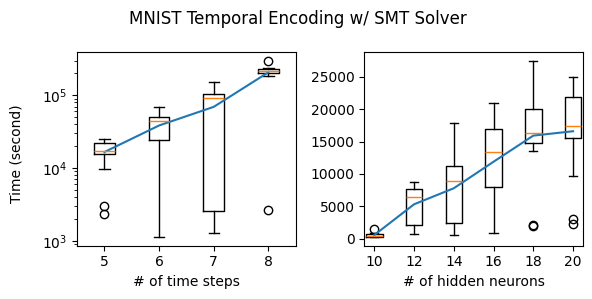

In [9]:
groups = [
    """log/06112104_mnist_latency_5_784_20_10_delta(1,).log log/06112105_mnist_latency_6_784_20_10_delta(1,).log log/06112138_mnist_latency_7_784_20_10_delta(1,).log log/06112138_mnist_latency_8_784_20_10_delta(1,).log""".split(' '),
    """log/06101421_mnist_latency_5_784_10_10_delta(1,).log log/06131254_mnist_latency_5_784_12_10_delta(1,).log log/06130909_mnist_latency_5_784_14_10_delta(1,).log log/06130704_mnist_latency_5_784_16_10_delta(1,).log log/06130832_mnist_latency_5_784_18_10_delta(1,).log log/06112104_mnist_latency_5_784_20_10_delta(1,).log""".split(' ')
]
plot_two_groups(groups,
                "MNIST Temporal Encoding w/ SMT Solver",
                [[5,6,7,8],[10,12,14,16,18,20]],
                ["# of time steps", "# of hidden neurons"],
                "Time (second)",
                ylogs=[True, False])

sample 58469 timeouted at file log/08151404_fmnist_latency_z3_6_784_20_10_delta(1,).log.
sample 18024 timeouted at file log/08151404_fmnist_latency_z3_6_784_20_10_delta(1,).log.
sample 48265 timeouted at file log/08151404_fmnist_latency_z3_6_784_20_10_delta(1,).log.
sample 16049 timeouted at file log/08151404_fmnist_latency_z3_6_784_20_10_delta(1,).log.
sample 44348 timeouted at file log/08151404_fmnist_latency_z3_6_784_20_10_delta(1,).log.
sample 48540 timeouted at file log/08151404_fmnist_latency_z3_6_784_20_10_delta(1,).log.
sample 35741 timeouted at file log/08151404_fmnist_latency_z3_6_784_20_10_delta(1,).log.
sample 48265 timeouted at file log/08120955_fmnist_latency_z3_8_784_20_10_delta(1,).log.
1 repeats detected.
1 repeats detected.


/opt/conda/envs/smt312/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/envs/smt312/lib/python3.12/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


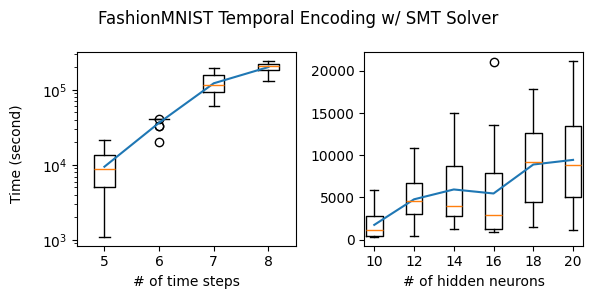

In [11]:
# groups = [
#     """log/08101717_fmnist_latency_z3_5_784_20_10_delta(1,).log log/08120947_fmnist_latency_z3_6_784_20_10_delta(1,).log log/08120948_fmnist_latency_z3_7_784_20_10_delta(1,).log log/08120955_fmnist_latency_z3_8_784_20_10_delta(1,).log""".split(' '),
#     """log/08101714_fmnist_latency_z3_5_784_10_10_delta(1,).log log/08102345_fmnist_latency_z3_5_784_12_10_delta(1,).log log/08102020_fmnist_latency_z3_5_784_14_10_delta(1,).log log/08101935_fmnist_latency_z3_5_784_16_10_delta(1,).log log/08101743_fmnist_latency_z3_5_784_18_10_delta(1,).log log/08101717_fmnist_latency_z3_5_784_20_10_delta(1,).log""".split(' ')
# ]
# plot_two_groups(groups,
#                 "FashionMNIST Temporal Encoding w/ SMT Solver",
#                 [[5,6,7,8],[10,12,14,16,18,20]],
#                 ["# of time steps", "# of hidden neurons"],
#                 "Time (second)",
#                 ylogs=[True, False])
groups = [
    """log/08101717_fmnist_latency_z3_5_784_20_10_delta(1,).log log/08151404_fmnist_latency_z3_6_784_20_10_delta(1,).log log/08120948_fmnist_latency_z3_7_784_20_10_delta(1,).log log/08120955_fmnist_latency_z3_8_784_20_10_delta(1,).log""".split(' '),
    """log/08151410_fmnist_latency_z3_5_784_10_10_delta(1,).log log/08152154_fmnist_latency_z3_5_784_12_10_delta(1,).log log/08152154_fmnist_latency_z3_5_784_14_10_delta(1,).log log/08101935_fmnist_latency_z3_5_784_16_10_delta(1,).log log/08151440_fmnist_latency_z3_5_784_18_10_delta(1,).log log/08101717_fmnist_latency_z3_5_784_20_10_delta(1,).log""".split(' ')
]
plot_two_groups(groups,
                "FashionMNIST Temporal Encoding w/ SMT Solver",
                [[5,6,7,8],[10,12,14,16,18,20]],
                ["# of time steps", "# of hidden neurons"],
                "Time (second)",
                ylogs=[True, False])

5 repeats detected.
5 repeats detected.


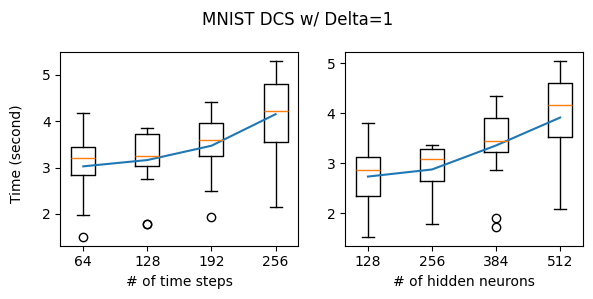

In [24]:
groups = [
    """log/08151714_rep_5_mnist_latency_np_64_784_512_10_delta(1,).log log/08151716_rep_5_mnist_latency_np_128_784_512_10_delta(1,).log log/08151719_rep_5_mnist_latency_np_192_784_512_10_delta(1,).log log/08151721_rep_5_mnist_latency_np_256_784_512_10_delta(1,).log""".split(' '),
    """log/08151806_rep_5_mnist_latency_np_256_784_128_10_delta(1,).log log/08151807_rep_5_mnist_latency_np_256_784_256_10_delta(1,).log log/08151810_rep_5_mnist_latency_np_256_784_384_10_delta(1,).log log/08151721_rep_5_mnist_latency_np_256_784_512_10_delta(1,).log""".split(' ')
]
plot_two_groups(groups,
                "MNIST DCS w/ Delta=1",
                [[64,128,192,256],[128, 256, 384, 512]],
                ["# of time steps", "# of hidden neurons"],
                "Time (second)",
                ylogs=[False, False])

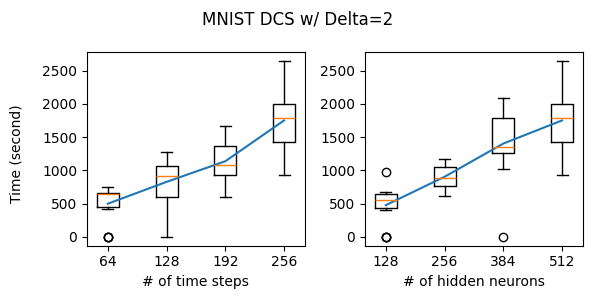

In [12]:
groups = [
    """log/08141748_mnist_latency_np_64_784_512_10_delta(2,).log log/08141748_mnist_latency_np_128_784_512_10_delta(2,).log log/08141748_mnist_latency_np_192_784_512_10_delta(2,).log log/08141754_mnist_latency_np_256_784_512_10_delta(2,).log""".split(' '),
    """log/08141325_mnist_latency_np_256_784_128_10_delta(2,).log log/08141337_mnist_latency_np_256_784_256_10_delta(2,).log log/08141442_mnist_latency_np_256_784_384_10_delta(2,).log log/08141754_mnist_latency_np_256_784_512_10_delta(2,).log""".split(' ')
]
plot_two_groups(groups,
                "MNIST DCS w/ Delta=2",
                [[64,128,192,256],[128, 256, 384, 512]],
                ["# of time steps", "# of hidden neurons"],
                "Time (second)",
                ylogs=[False, False])

In [13]:
# colors = [*mcolors.TABLEAU_COLORS.keys()]
colors = ["forestgreen", "blueviolet", "tab:red",]

def compare_plot_files(files:list[list[LiteralString]],
                       title:str, xticks:Sequence[int],
                       xlabel:str, ylabel:str,
                       group_labels:list[str]|None=None,
                       xtick_labels:list[str]|None=None,
                       xwidths:list[float]|None=None,
                       log:bool=False):
    assert all(len(files[0]) == len(group) for group in files[1:]), "File lists must have the same length."
    
    if log:
        plt.yscale("log")
    for group_idx, group in enumerate(files):
        group_color = colors[group_idx]
        times_dict = extract_log(group)
        times_array:np.ndarray[tuple[Literal[14],int], np._dtype[np.float_]] = np.array(list(times_dict.values()))
        
        nan_masked_times = np.copy(times_array)
        nan_masked_times[nan_masked_times==float("inf")] = np.nan
        mean, std = np.nanmean(nan_masked_times, axis=0), np.nanstd(nan_masked_times, axis=0)
        median = np.nanmedian(nan_masked_times, axis=0)
        d1, d9 = np.nanquantile(nan_masked_times, 0.1, axis=0), np.nanquantile(nan_masked_times, 0.9, axis=0)
        q1, q3 = np.nanquantile(nan_masked_times, 0.25, axis=0), np.nanquantile(nan_masked_times, 0.75, axis=0)
        if group_labels is not None:
            plt.plot(xticks, median, label=group_labels[group_idx], color=group_color)
        else:
            plt.plot(xticks, median, label="median time", color=group_color)
        plt.fill_between(xticks, np.nanmax(nan_masked_times, axis=0), np.nanmin(nan_masked_times, axis=0), alpha=0.05, color=group_color)
        plt.fill_between(xticks, d9, d1, alpha=0.1, color=group_color)
        plt.fill_between(xticks, q3, q1, alpha=0.2, color=group_color)
    
    # plt.yscale("log")
    plt.title(title)
    if xtick_labels:
        plt.xticks(xticks, labels=xtick_labels)
    else:
        plt.xticks(xticks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.legend()
    plt.show()

In [14]:
def compare_hist_files(files:list[list[LiteralString]],
                       title:str,
                       xlabel:str,
                       ylabel:str,
                       group_labels:list[str]|None=None):
    hist_x:list[list[float]] = [list() for _ in range(len(files))]
    M = -float("inf")
    for group_idx, group_files in enumerate(files):
        times_dict = extract_log(group_files)
        for sample_times in times_dict.values():
            hist_x[group_idx].extend(sample_times)
            for time in sample_times:
                if time != float("inf"):
                    M = max(time, M)
        # array = np.array(list(times_dict.values()))
        # M = max(M, np.max(array[array!=float("inf")]))
        # label_perm = []
        # for sample_idx, times_over_sample in times_dict.items():
        #     label_perm.append(sample_idx)
        #     for sample_time in times_over_sample:
        #         hist_x[group_idx].append(sample_time)
    
    print(hist_x)
    
    # inf_representation = M + 10**np.floor(np.log10(M))
    inf_representation = M
    for group in hist_x:
        for i, time in enumerate(group):
            group[i] = time if time != float("inf") else inf_representation
    
    if group_labels is not None:
        plt.hist(hist_x, label=group_labels, orientation='horizontal')
    else:
        plt.hist(hist_x, orientation='horizontal')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

sample 48265 timeouted at file log/08062232_mnist_baseline_z3_5_784_10_10_delta_(1,).log.
sample 44348 timeouted at file log/08062232_mnist_baseline_z3_5_784_10_10_delta_(1,).log.
sample 7296 timeouted at file log/08062234_mnist_baseline_z3_5_784_10_10_delta_(3,).log.


/tmp/ipykernel_1805120/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


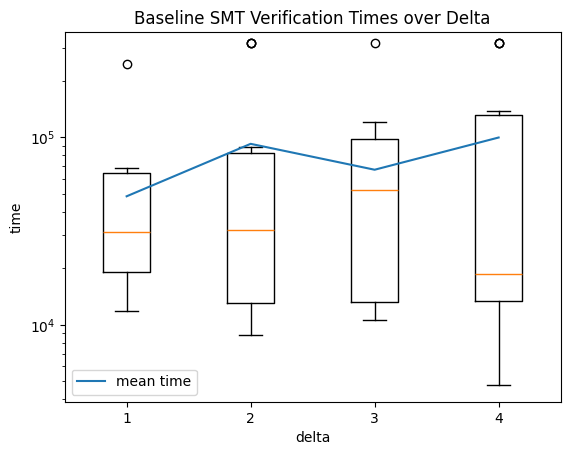

sample 6717 timeouted at file log/07250940_mnist_latency_5_784_10_10_delta(3,).log.
sample 7296 timeouted at file log/07250940_mnist_latency_5_784_10_10_delta(4,).log.
sample 58469 timeouted at file log/07250940_mnist_latency_5_784_10_10_delta(4,).log.
sample 1639 timeouted at file log/07250940_mnist_latency_5_784_10_10_delta(4,).log.
sample 16049 timeouted at file log/07250940_mnist_latency_5_784_10_10_delta(4,).log.
sample 9144 timeouted at file log/07250940_mnist_latency_5_784_10_10_delta(4,).log.
sample 48540 timeouted at file log/07250940_mnist_latency_5_784_10_10_delta(4,).log.


/opt/conda/envs/smt312/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_1805120/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


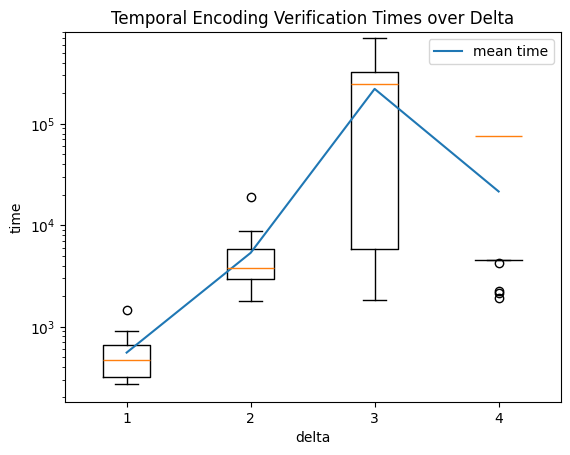

sample 9144 timeouted at file log/08062240_mnist_baseline_np_5_784_10_10_delta_(3,).log.
sample 48598 timeouted at file log/08062240_mnist_baseline_np_5_784_10_10_delta_(3,).log.
sample 48598 timeouted at file log/08070837_mnist_baseline_np_5_784_10_10_delta_(4,).log.


/tmp/ipykernel_1805120/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


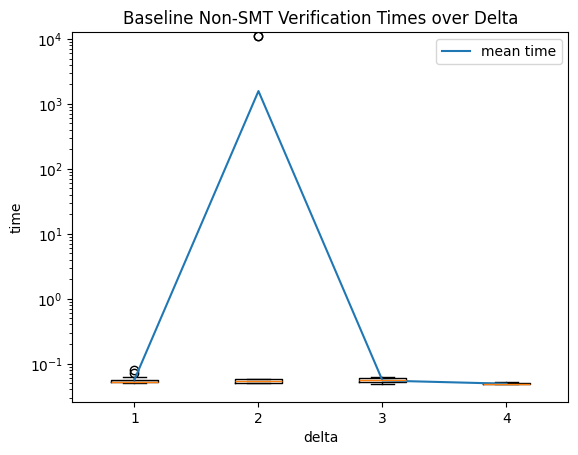

FileNotFoundError: [Errno 2] No such file or directory: 'log/08062309_mnist_latency_np_5_784_10_10_delta(4,).log'

In [15]:
# from delta=1 to 5 in 5 step, 10 hidden rate baseline, with 14 samples
files1 = """log/08062232_mnist_baseline_z3_5_784_10_10_delta_(1,).log log/08062233_mnist_baseline_z3_5_784_10_10_delta_(2,).log log/08062234_mnist_baseline_z3_5_784_10_10_delta_(3,).log log/08062234_mnist_baseline_z3_5_784_10_10_delta_(4,).log""".split(' ')
plot_files(files1,
           "Baseline SMT Verification Times over Delta",
           range(1, 4+1),
           "delta",
           "time")
files2 = """log/06101421_mnist_latency_5_784_10_10_delta(1,).log log/07250939_mnist_latency_5_784_10_10_delta(2,).log log/07250940_mnist_latency_5_784_10_10_delta(3,).log log/07250940_mnist_latency_5_784_10_10_delta(4,).log""".split(' ')
plot_files(files2,
           "Temporal Encoding Verification Times over Delta",
           [*range(1, 4+1)],
           "delta",
           "time")

files3 = """log/08062246_mnist_baseline_np_5_784_10_10_delta_(1,).log log/08062246_mnist_baseline_np_5_784_10_10_delta_(2,).log log/08062240_mnist_baseline_np_5_784_10_10_delta_(3,).log log/08070837_mnist_baseline_np_5_784_10_10_delta_(4,).log""".split(' ')
plot_files(files3,
           "Baseline Non-SMT Verification Times over Delta",
           [*range(1, 4+1)],
           "delta",
           "time")

files4 = """log/08061731_mnist_latency_np_5_784_10_10_delta(1,).log log/08062011_mnist_latency_np_5_784_10_10_delta(2,).log log/08062016_mnist_latency_np_5_784_10_10_delta(3,).log log/08062309_mnist_latency_np_5_784_10_10_delta(4,).log""".split(' ')
plot_files(files4,
           "Temporal Encoding Non-SMT Verification Times over Delta",
           [*range(1, 4+1)],
           "delta",
           "time")

# from delta=1 to 5 in 5 step, 10 hidden rate baseline, with 14 samples
files = [files1, files2]
compare_plot_files(files,
           "Verification Times over Delta",
           range(1, 4+1),
           "delta",
           "time",
           group_labels=["Baseline(Rate) median", "Temporal median"],
           log=True)

/tmp/ipykernel_3196371/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


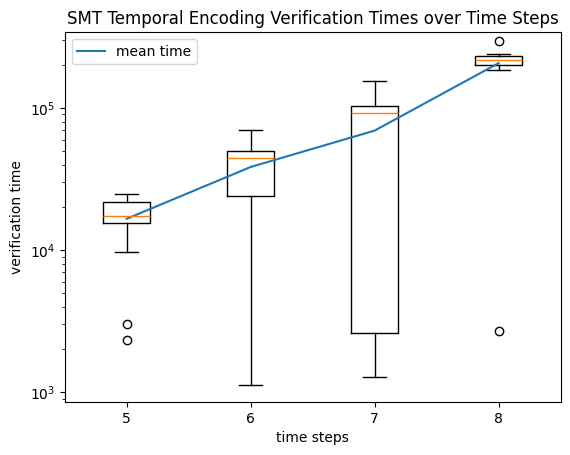

/tmp/ipykernel_3196371/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


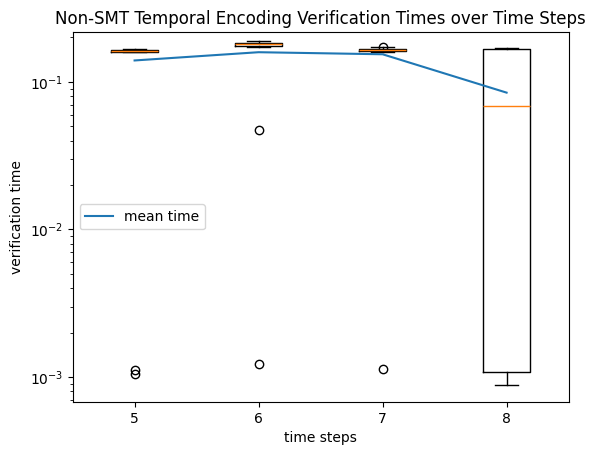

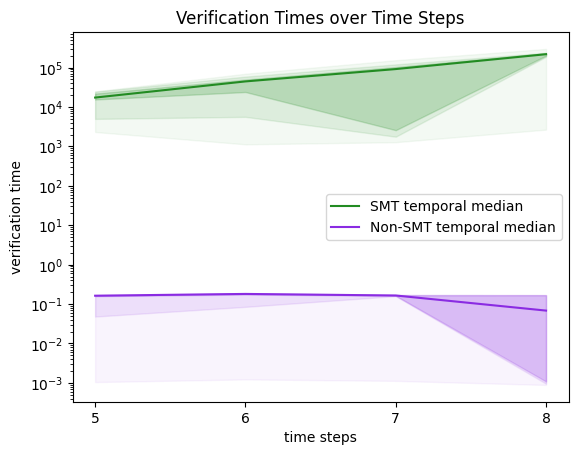

In [ ]:
# files1 = """log/06112259_baseline_5_784_20_10_delta_(1,).log log/06112307_baseline_6_784_20_10_delta_(1,).log log/06120801_baseline_7_784_20_10_delta_(1,).log log/06120949_baseline_8_784_20_10_delta_(1,).log""".split(' ')
# plot_files(files1,
#            "Rate Encoding Verification Times over Time Steps",
#            [5, 6, 7, 8],
#            "time steps",
#            "verification time")
files2 = """log/06112104_mnist_latency_5_784_20_10_delta(1,).log log/06112105_mnist_latency_6_784_20_10_delta(1,).log log/06112138_mnist_latency_7_784_20_10_delta(1,).log log/06112138_mnist_latency_8_784_20_10_delta(1,).log""".split(' ')
plot_files(files2,
           "SMT Temporal Encoding Verification Times over Time Steps",
           [5, 6, 7, 8],
           "time steps",
           "verification time")
files3 = """log/08062027_mnist_latency_np_5_784_20_10_delta(1,).log log/08062027_mnist_latency_np_6_784_20_10_delta(1,).log log/08062028_mnist_latency_np_7_784_20_10_delta(1,).log log/08062028_mnist_latency_np_8_784_20_10_delta(1,).log""".split(' ')
plot_files(files3,
           "Non-SMT Temporal Encoding Verification Times over Time Steps",
           [5, 6, 7, 8],
           "time steps",
           "verification time")
files = [files2, files3]
compare_plot_files(
    files,
    "Verification Times over Time Steps",
    [5, 6, 7, 8],
    "time steps",
    "verification time",
    group_labels=["SMT temporal median", "Non-SMT temporal median"],
    log=True
)

sample 7296 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 6717 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 14628 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 1639 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 41905 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 16049 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 48598 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 9144 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 48540 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 35741 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 14628 timeouted at file log/06140407_baseline_5_784_14_10_delta_(1,).log.
sample 58469 timeouted at file log/06140407_baseline_5_784_14_10_delta_(1,).log.
sample 1639 timeouted at file lo

/opt/conda/envs/smt312/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_3196371/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


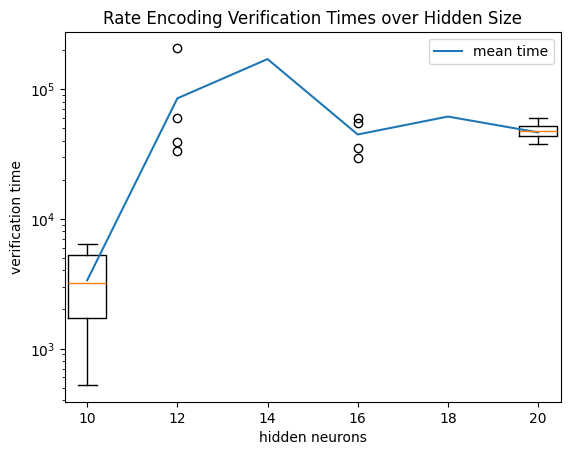

/tmp/ipykernel_3196371/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


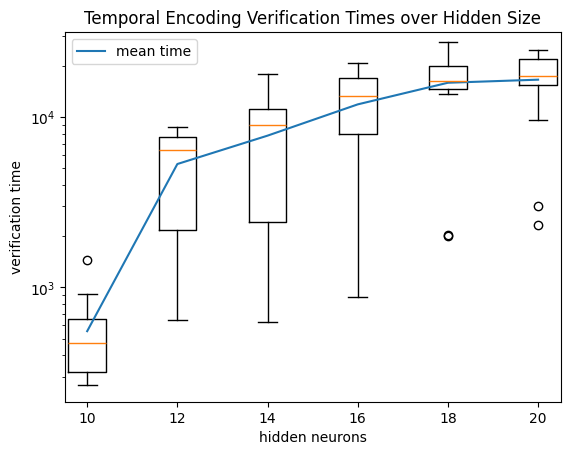

sample 7296 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 6717 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 14628 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 1639 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 41905 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 16049 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 48598 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 9144 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 48540 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 35741 timeouted at file log/06140808_baseline_5_784_12_10_delta_(1,).log.
sample 14628 timeouted at file log/06140407_baseline_5_784_14_10_delta_(1,).log.
sample 58469 timeouted at file log/06140407_baseline_5_784_14_10_delta_(1,).log.
sample 1639 timeouted at file lo

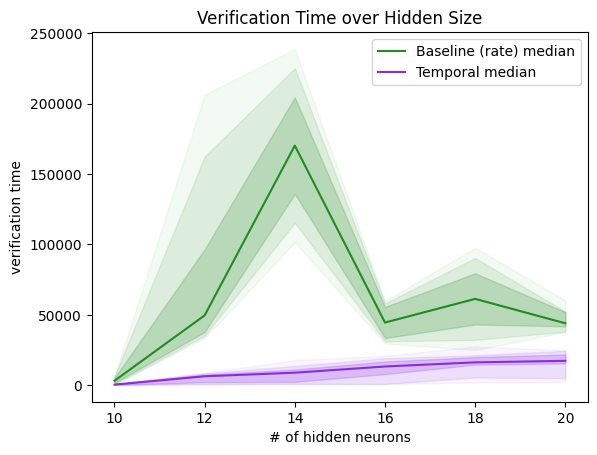

In [ ]:
files1 = """log/06101211_baseline_5_784_10_10_delta_(1,).log log/06140808_baseline_5_784_12_10_delta_(1,).log log/06140407_baseline_5_784_14_10_delta_(1,).log log/06131502_baseline_5_784_16_10_delta_(1,).log log/06131451_baseline_5_784_18_10_delta_(1,).log log/06112259_baseline_5_784_20_10_delta_(1,).log""".split(' ')
plot_files(files1,
           "Rate Encoding Verification Times over Hidden Size",
           [10, 12, 14, 16, 18, 20],
           "hidden neurons",
           "verification time")

files2 = """log/06101421_mnist_latency_5_784_10_10_delta(1,).log log/06131254_mnist_latency_5_784_12_10_delta(1,).log log/06130909_mnist_latency_5_784_14_10_delta(1,).log log/06130704_mnist_latency_5_784_16_10_delta(1,).log log/06130832_mnist_latency_5_784_18_10_delta(1,).log log/06112104_mnist_latency_5_784_20_10_delta(1,).log""".split(' ')
plot_files(files2,
           "Temporal Encoding Verification Times over Hidden Size",
           [10, 12, 14, 16, 18, 20],
           "hidden neurons",
           "verification time")

files = [files1, files2]
compare_plot_files(files,
                   "Verification Time over Hidden Size",
                   [10, 12, 14, 16, 18, 20],
                   "# of hidden neurons",
                   "verification time",
                   group_labels=["Baseline (rate) median", "Temporal median"])

sample 14628 timeouted at file log/06112259_baseline_5_784_20_10_delta_(1,).log.
sample 58469 timeouted at file log/06112259_baseline_5_784_20_10_delta_(1,).log.
[[2325.0809502601624, 2998.619579553604, 9642.988301992416, 15324.90985584259, 16149.906563043594, 16276.944894313812, 16764.502267837524, 17956.199605226517, 18769.652549743652, 19489.299103975296, 22672.438860177994, 24489.46478819847, 24525.586050510406, 24903.36334180832], [37909.8698656559, 37981.07683134079, 38484.10595583916, 42988.436712026596, 43589.13450527191, 43710.76174426079, 44319.03783369064, 50390.13312339783, 51849.795306921005, 52171.84709525108, 52364.08387327194, 60248.29201555252, inf, inf]]


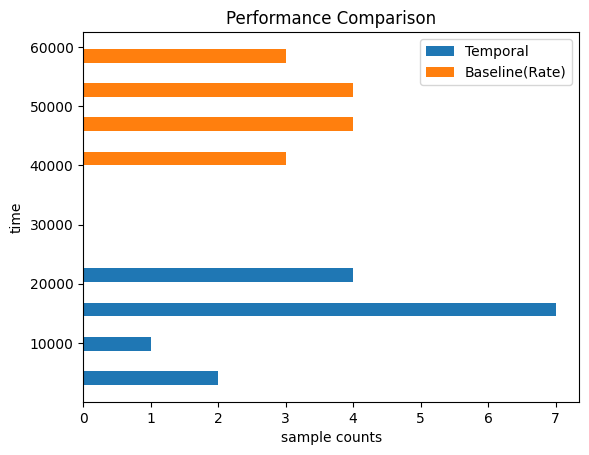

In [ ]:
files = [
    """log/06112104_mnist_latency_5_784_20_10_delta(1,).log""".split(' '),
    """log/06112259_baseline_5_784_20_10_delta_(1,).log""".split(' ')
]
compare_hist_files(files,
           "Performance Comparison",
           "sample counts",
           "time",
           group_labels=["Temporal", "Baseline(Rate)"])

sample 16049 timeouted at file log/06021842_mnist_latency_7_784_14_10.log.


/tmp/ipykernel_3196371/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


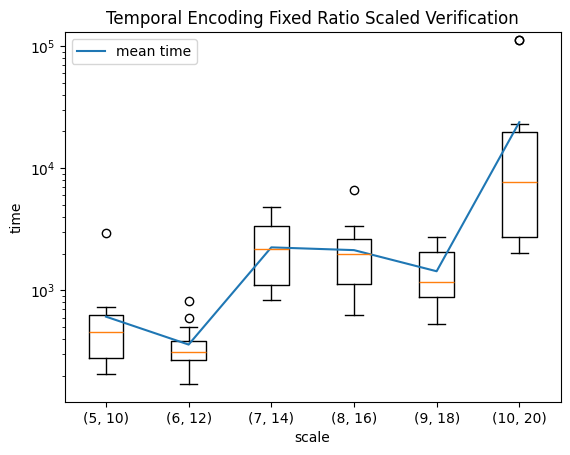

In [ ]:
# delta = 1, fixed step/hidden ratio, increasing step, hidden.
files = """log/05312233_mnist_latency_5_784_10_10.log
log/06021842_mnist_latency_6_784_12_10.log
log/06021842_mnist_latency_7_784_14_10.log
log/06021843_mnist_latency_8_784_16_10.log
log/06021845_mnist_latency_9_784_18_10.log
log/06021845_mnist_latency_10_784_20_10.log""".split('\n')
plot_files(files,
           "Temporal Encoding Fixed Ratio Scaled Verification",
           range(1,6+1),
           "scale",
           "time",
           xtick_labels=[str(x) for x in zip(range(5,11),range(10,22,2))])

sample 9144 timeouted at file log/06100526_mnist_latency_128_784_10_10_delta(1,).log.


/tmp/ipykernel_3196371/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


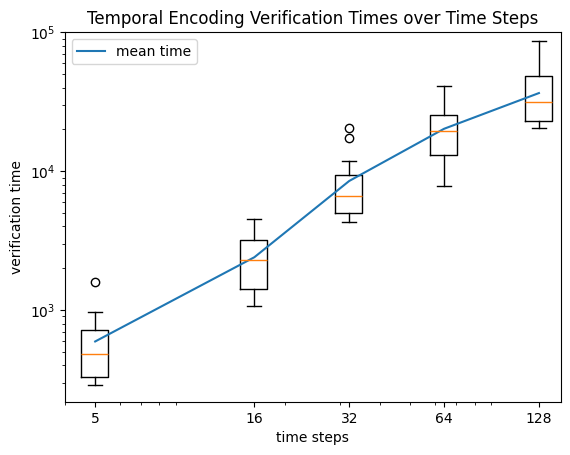

In [ ]:
files = """log/06091004_mnist_latency_5_784_10_10_delta(1,).log log/06091136_mnist_latency_16_784_10_10_delta(1,).log log/06091136_mnist_latency_32_784_10_10_delta(1,).log log/06091136_mnist_latency_64_784_10_10_delta(1,).log log/06100526_mnist_latency_128_784_10_10_delta(1,).log""".split(' ')
plt.xscale("log")
plt.xlim(4, 150)
plot_files(files,
           "Temporal Encoding Verification Times over Time Steps",
           [5, 16, 32, 64, 128],
           "time steps",
           "verification time",
           xwidths=np.array([5, 16, 32, 64, 128])/5)

/tmp/ipykernel_3196371/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


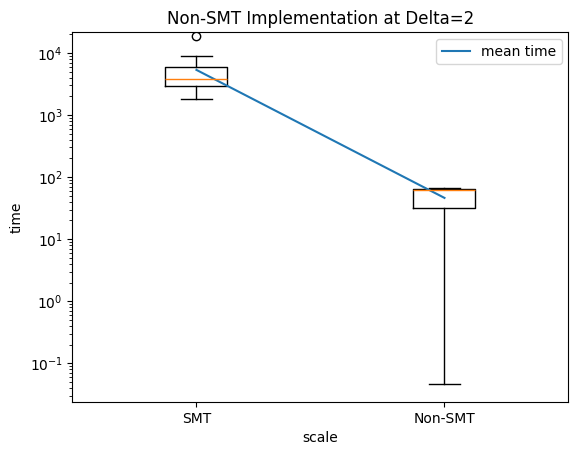

In [ ]:
files = """log/07250939_mnist_latency_5_784_10_10_delta(2,).log log/08062011_mnist_latency_np_5_784_10_10_delta(2,).log""".split(' ')
plot_files(files,
           "Non-SMT Implementation at Delta=2",
           range(1,2+1),
           "scale",
           "time",
           xtick_labels=["SMT", "Non-SMT"])

/tmp/ipykernel_1189874/1067540265.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bot - 0.15*height, top + 0.15*height)


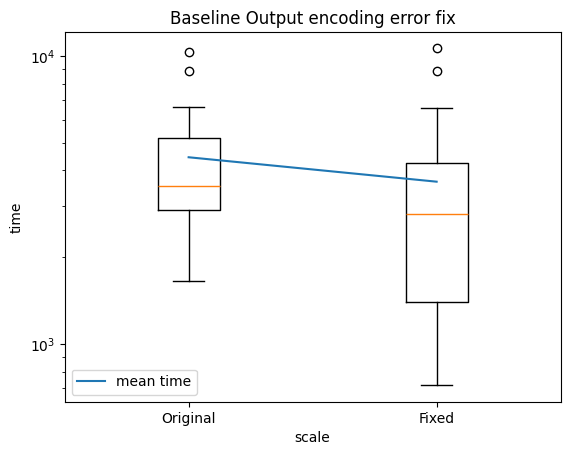

In [ ]:
files = """log/06071233_baseline_5_784_10_10_delta_(1,).log log/06071307_baseline_5_784_10_10_delta_(1,).log""".split(' ')
plot_files(files,
           "Baseline Output encoding error fix",
           range(1,2+1),
           "scale",
           "time",
           xtick_labels=["Original", "Fixed"])

In [ ]:
img = np.array([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 0, 0, 2, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 0, 0, 0, 1, 4, 4, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 1, 4, 2, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 3, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 1, 3, 4, 2, 0, 2, 0, 0, 0, 3, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 3, 4, 4, 3, 0, 0, 0, 0, 0, 3, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 2, 4, 4, 4, 1, 0, 0, 0, 0, 1, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 4, 4, 4, 3, 0, 0, 0, 0, 0, 1, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 0, 1, 3, 4, 2, 0, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2, 1, 1, 3, 4, 4, 2, 0, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 1, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 3, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 1, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 1, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 3, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4]])
pertd_img = np.copy(img)
pertd_img[25,7] -= 1
pertd_img[12,17] += 2
pertd_img[5,25] -= 1

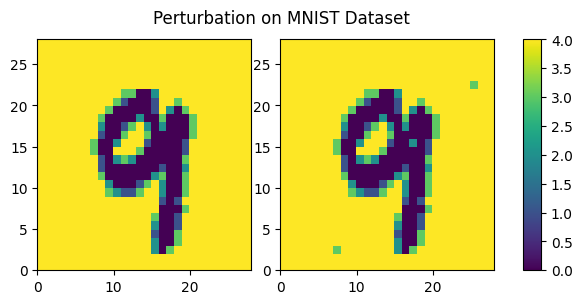

In [ ]:

fig, axes = plt.subplots(1, 3, width_ratios=[0.48, 0.48, 0.04])
fig.set_size_inches(6.5, 3)
axes[0].pcolor(img[::-1])
pc = axes[1].pcolor(pertd_img[::-1])

fig.colorbar(pc, ax=axes[1], cax=axes[2])
fig.suptitle("Perturbation on MNIST Dataset")
fig.savefig("PertExample.pdf")